# Predictive Maintenance on Aircraft Dataset  
The dataset used in this notebook is publically available and can be downloaded here:  
https://data.nasa.gov/Aerospace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6/about_data  
  
The datasets contain multiple multivariate time series from different engines, divided into training and test subsets. Each engine has varying initial wear and manufacturing differences, considered normal and not faults. Three operational settings significantly impact performance, and sensor noise contaminates the data.

Initially, engines operate normally and develop faults over time. In the training set, faults progress to failure, while the test set ends before failure. The goal is to predict the remaining operational cycles before failure in the test set, with provided true Remaining Useful Life (RUL) values.

Data is provided as a zip-compressed text file with 26 columns, each row representing a single operational cycle:

1. Unit number
2. Time, in cycles
3. Operational setting 1
4. Operational setting 2
5. Operational setting 3
6. Sensor measurements 1-26

## Import Libraries

In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

## Import Datasets

In [378]:
# Load the data
train_data = pd.read_csv("Kaggle_Dataset/PM_train.txt", sep=" ", header=None)
test_data = pd.read_csv("Kaggle_Dataset/PM_test.txt", sep=" ", header=None)
ground_truth = pd.read_csv("Kaggle_Dataset/PM_truth.txt", sep=" ", header=None)

### Drop Empty Columns  
To clean up the data, we are dropping all empty columns.

In [379]:
# Drop empty columns
train_data.dropna(axis=1, inplace=True)
test_data.dropna(axis=1, inplace=True)
ground_truth.dropna(axis=1, inplace=True)

### Label Columns  
We are labeling the columns according to the dataset documentation to enhance readability and understanding.

In [380]:
# Add column names
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# Label training and test data
train_data.columns = cols_names
test_data.columns = cols_names
# Label ground truth data with column name 'ttf'
ground_truth.columns = ['ttf']

### Sort columns by the attributes 'id' and 'cycle'

In [381]:
train_data = train_data.sort_values(['id', 'cycle'])
test_data = test_data.sort_values(['id', 'cycle'])

### Normalize training data in all columns that are different to 'id' and 'cycle' using Zscore

In [382]:
# Function to normalize data
def normalize_data(data, norm_cols):
    min_max_scaler = MinMaxScaler()
    norm_data = pd.DataFrame(min_max_scaler.fit_transform(data[norm_cols]), columns=norm_cols, index=data.index)
    return data[['id', 'cycle']].join(norm_data)

# Identify columns to normalize
norm_cols = train_data.columns.difference(['id', 'cycle'])

# Normalize train data
train_data = normalize_data(train_data, norm_cols)

# Normalize test data
test_data = normalize_data(test_data, norm_cols)

## Feature Engineering

In [383]:
# Method to prepare training data by calculating Time-to-Failure (TTF) and binary classification label
def prepare_train_data(df, period):
    # Find the maximum cycle for each engine
    df_max_cycle = pd.DataFrame(df.groupby('id')['cycle'].max())
    df_max_cycle.reset_index(level=0, inplace=True)
    df_max_cycle.columns = ['id', 'last_cycle']

    # Merge maximum cycle information with the original dataframe
    df = pd.merge(df, df_max_cycle, on='id')

    # Calculate Time-to-Failure (TTF)
    df['ttf'] = df['last_cycle'] - df['cycle']

    # Drop unnecessary column
    df.drop(['last_cycle'], axis=1, inplace=True)

    # Create binary classification label based on TTF
    df['label_bc'] = df['ttf'].apply(lambda x: 1 if x <= period else 0)

    return df

# Method to prepare testing data by calculating TTF, merging with ground truth, and creating binary classification label
def prepare_test_data(df_test, df_truth, period):
    # Find the last cycle for each engine in the test data
    df_test_last_cycle = pd.DataFrame(df_test.groupby('id')['cycle'].max())
    df_test_last_cycle.reset_index(level=0, inplace=True)
    df_test_last_cycle.columns = ['id', 'last_cycle']

    # Merge maximum cycle information with the test dataframe
    df_test = pd.merge(df_test, df_test_last_cycle, on='id')

    # Filter rows to include only the last cycle for each engine
    df_test = df_test[df_test['cycle'] == df_test['last_cycle']]

    # Drop unnecessary column
    df_test.drop(['last_cycle'], axis=1, inplace=True)

    # Reset index to ensure correct concatenation
    df_test.reset_index(drop=True, inplace=True)

    # Concatenate test data with ground truth
    df_test = pd.concat([df_test, df_truth], axis=1)

    # Create binary classification label based on TTF
    df_test['label_bnc'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)

    return df_test

In [384]:
# Extract features using a rolling window of 5 cycles for both training and test data
df_train_extracted_features = add_features(train_data, 5)
df_test_extracted_features = add_features(test_data, 5)

# Prepare data by calculating TTF and creating binary labels for failure within 30 cycles
train_data = prepare_train_data(df_train_extracted_features, 30)
test_data = prepare_test_data(df_test_extracted_features, ground_truth, 30)

## Exploratory Data Analysis (EDA)

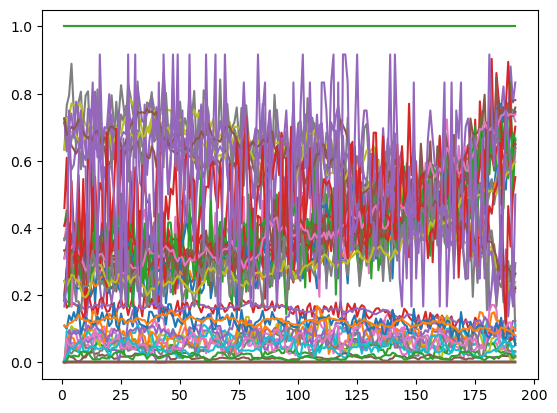

In [385]:
# Plot dynamic sensor data
for i in train_data.columns.difference(['id', 'cycle', 'label_bc', 'ttf']):
   plt.plot(train_data[train_data["id"] == 1]["cycle"], train_data[i][train_data["id"] == 1], label=i)
    #print(i)
plt.show()

Features with low correlation to target variable: ['setting1', 'setting2', 's6']
Features with high correlation to target variable: ['s2', 's4', 's7', 's11', 's12', 's15', 's17', 's20', 's21']


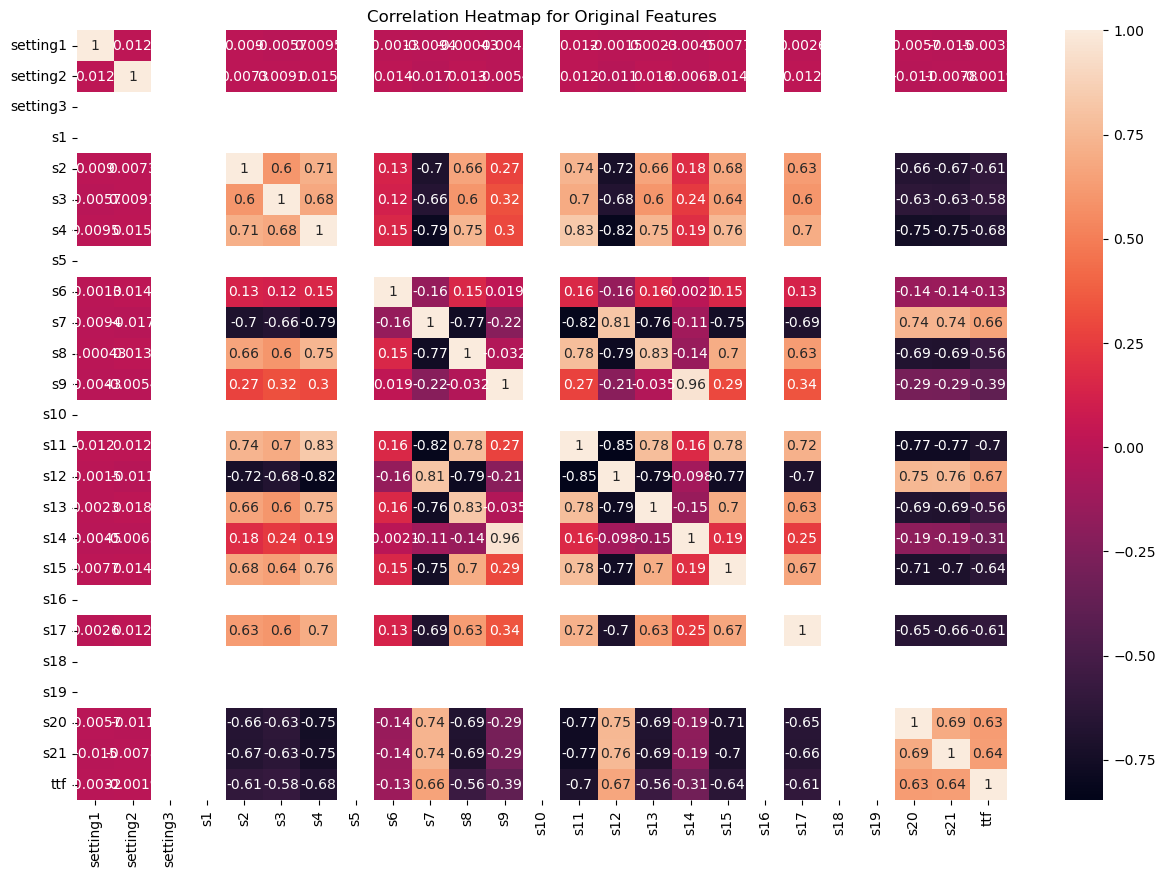

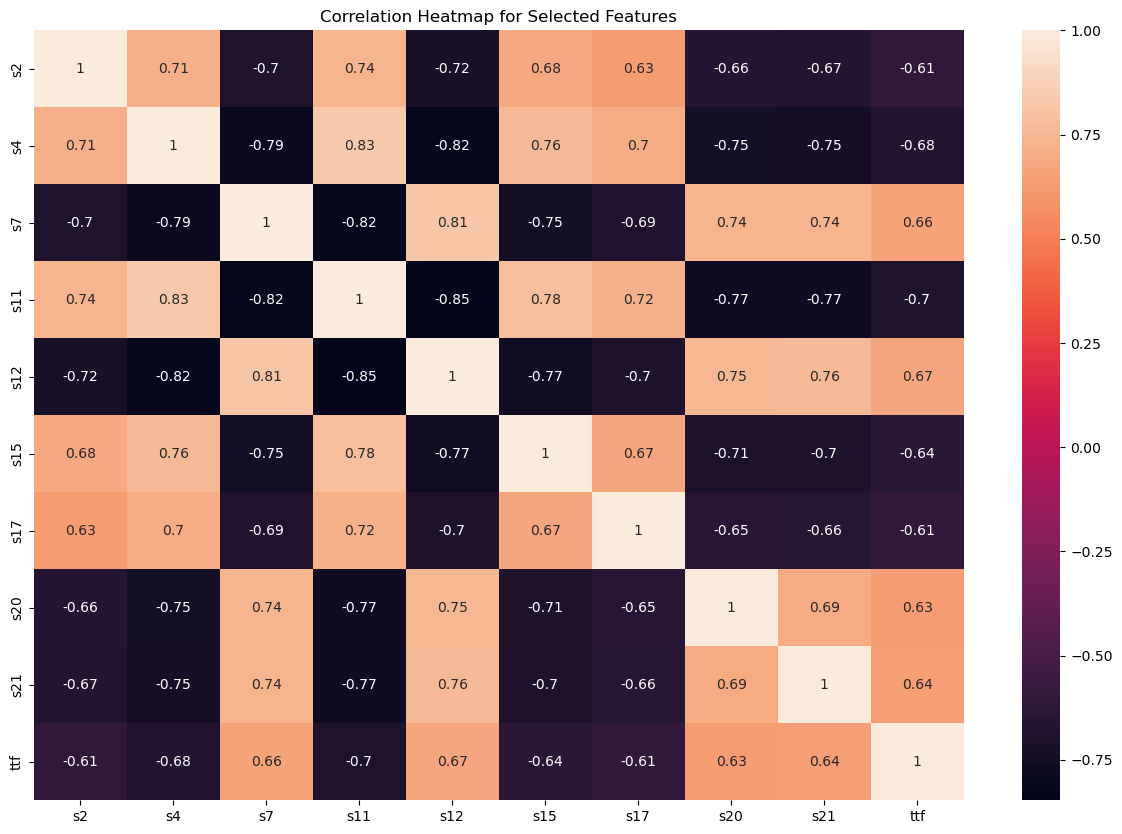

In [386]:
# Original features in the dataset
features_orig = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

# Create a heatmap to visualize correlations between original features and target variable
plt.figure(figsize=(15, 10))
corr_orig = train_data[features_orig + ['ttf']].corr()
sns.heatmap(corr_orig, annot=True)
plt.title("Correlation Heatmap for Original Features")

# Determine features with low and high correlation to the target variable
correlation_with_target = corr_orig['ttf']
high_corr_threshold = 0.6
low_corr_threshold = 0.3

features_high_corr = correlation_with_target[abs(correlation_with_target) > high_corr_threshold].index.tolist()
features_low_corr = correlation_with_target[abs(correlation_with_target) < low_corr_threshold].index.tolist()

# Remove the target variable from the lists
if 'ttf' in features_high_corr:
    features_high_corr.remove('ttf')
if 'ttf' in features_low_corr:
    features_low_corr.remove('ttf')

# Display features with low and high correlation
print("Features with low correlation to target variable:", features_low_corr)
print("Features with high correlation to target variable:", features_high_corr)

# Choose features to use
features = features_high_corr

# Create a heatmap to visualize correlations between selected features and target variable
plt.figure(figsize=(15, 10))
corr_selected = train_data[features + ['ttf']].corr()
sns.heatmap(corr_selected, annot=True)
plt.title("Correlation Heatmap for Selected Features")

# Prepare training and testing data
X_train = train_data[features]
y_train = train_data['ttf']
X_test = test_data[features]
y_test = test_data['ttf']

# Scale the features using Min-Max scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Model training

In [387]:
# Training the model	
# best params n_estimators=40, max_depth=2, max_features=1: r2=0.634, RMSE = 25.15, MAE = 19.88
model = RandomForestRegressor(n_estimators=40, max_depth=2, random_state=42, max_features=1, n_jobs=-1, verbose=1)

history = model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [388]:
# Evaluate the model
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# RMSE measures the differences between predicted values by the model and the actual values
# It's calculated as the square root of the average of the squared differences between the predicted and actual values
print("RMSE: ", rmse) # 0 means perfect prediction
# MAE measures the average magnitude of the errors in a set of predictions, without considering their direction
# It's calculated as the average of the absolute errors between the predicted and actual values
print("MAE: ", mae) # 0 means perfect prediction
# R2 measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s)
# It's calculated as 1 - (sum of squared errors / sum of squared differences between the actual values and the mean of the actual values)
print("R2: ", r2) # 1 means perfect prediction

RMSE:  25.23669277915753
MAE:  20.179837637151376
R2:  0.6311877501175642


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished


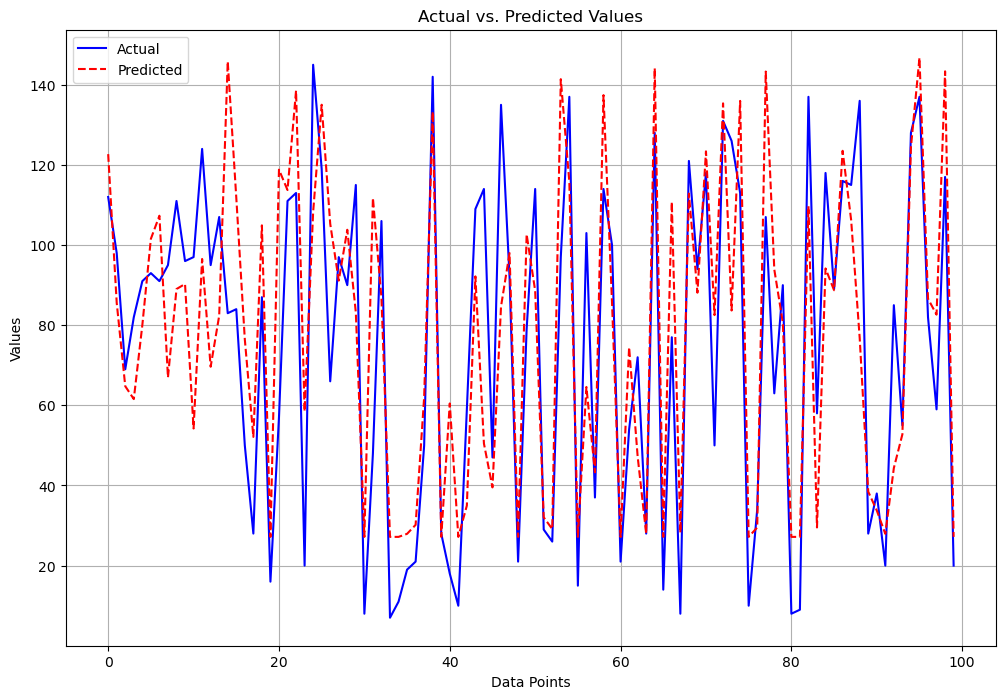

In [389]:
import matplotlib.pyplot as plt

# Data visualization
plt.figure(figsize=(12, 8))
plt.plot(y_test, label='Actual', color='blue', linestyle='-')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.legend()
plt.show()